In [73]:
from collagen_segment import segment_stack, get_pores, get_holes
import numpy as np
import matplotlib.pyplot as plt 
import os
from nn.UNet import UNet
import torch as th
from torchvision import transforms
import tqdm
import pandas as pd
import seaborn as sns
from skimage.measure import label, regionprops

In [67]:
metadata_file = "/mnt/d/d_merged12/dataset.csv"
with open(metadata_file, 'r') as f:
    files, conditions = [], []
    for line in f:
        file, cond = line.strip().split(',')
        files.append(file)
        conditions.append(cond)

dataset_path = "/mnt/d/d_merged12/dataset/"
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
model = UNet(1, 1).to(device)
model.load_state_dict(th.load("/home/quantum/MScThesisCode/unet.th", weights_only=True))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [68]:
d_3d = {}
d_2d = {}
for cond in conditions:
    d_2d[cond] = []
    d_3d[cond] = []

In [69]:
transform = transforms.Compose([
        transforms.ToTensor(),
])
for file, cond in tqdm.tqdm(zip(files, conditions)):
    segment = segment_stack(model, os.path.join(dataset_path, file), transform, device)
    
    d_3d[cond].extend(get_pores(segment))
    d_2d[cond].extend(get_holes(segment))

22it [01:29,  4.07s/it]


In [70]:
df_2d = pd.DataFrame([(cat, vol) for cat, vols in d_2d.items() for vol in vols], 
                  columns=["Category", "Volume"])
df_3d = pd.DataFrame([(cat, vol) for cat, vols in d_3d.items() for vol in vols], 
                     columns=["Category", "Volume"])

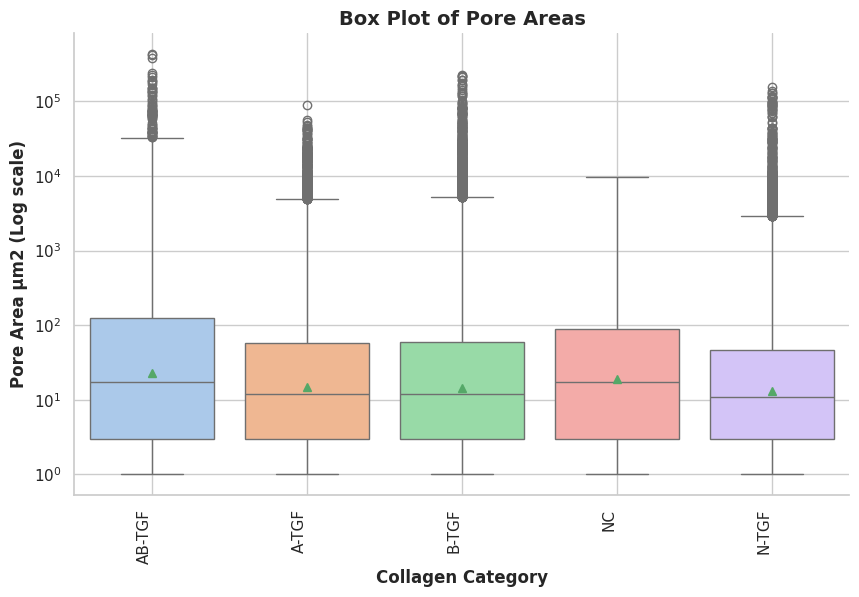

In [71]:
sns.set_theme(style="whitegrid")

# Create boxplot for each category
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_2d, x="Category", y="Volume", 
    log_scale=True, 
    palette="pastel", 
    hue="Category",
    showmeans=True
)

# Improve readability
plt.xlabel("Collagen Category", fontsize=12, fontweight='bold')
plt.ylabel("Pore Area µm2 (Log scale)", fontsize=12, fontweight='bold')
plt.title("Box Plot of Pore Areas", fontsize=14, fontweight='bold')

# Rotate category labels if needed
plt.xticks(rotation=90, ha='right')

# Remove grid lines
plt.grid(True)  # Removes background grid

# Remove top & right borders for a clean look
sns.despine()

plt.show()


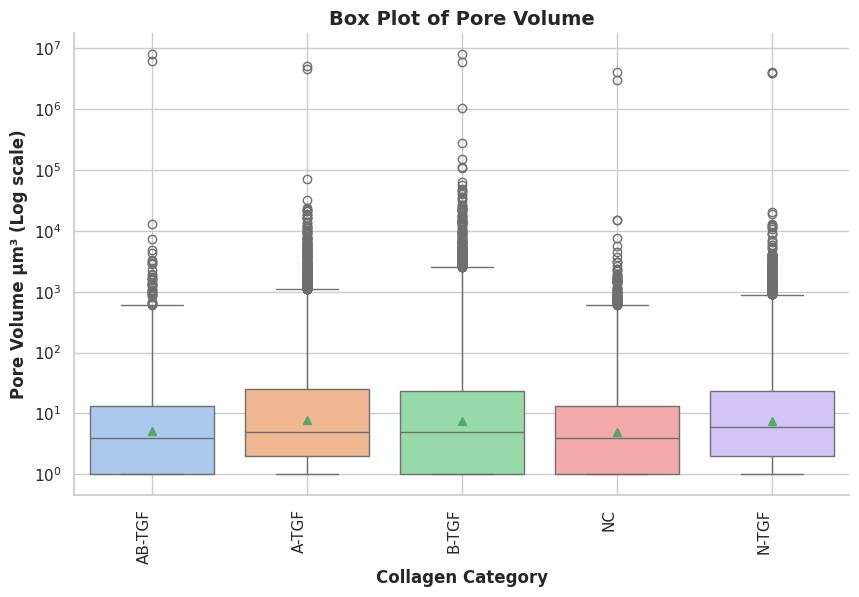

In [72]:
sns.set_theme(style="whitegrid")

# Create boxplot for each category
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_3d, x="Category", y="Volume", 
    log_scale=True, 
    palette="pastel", 
    hue="Category",
    showmeans=True
)

# Improve readability
plt.xlabel("Collagen Category", fontsize=12, fontweight='bold')
plt.ylabel("Pore Volume µm³ (Log scale)", fontsize=12, fontweight='bold')
plt.title("Box Plot of Pore Volume", fontsize=14, fontweight='bold')

# Rotate category labels if needed
plt.xticks(rotation=90, ha='right')

# Remove grid lines
plt.grid(True)  # Removes background grid

# Remove top & right borders for a clean look
sns.despine()

plt.show()


In [78]:
from scipy.stats import kruskal
# Kruskal-Wallis test (non-parametric alternative)
kruskal_result_2d = kruskal(*[df_2d[df_2d['Category'] == cat]['Volume'] for cat in df_2d['Category'].unique()])
kruskal_result_3d = kruskal(*[df_3d[df_3d['Category'] == cat]['Volume'] for cat in df_3d['Category'].unique()])
print('Kruskal-Wallis-2D result:', kruskal_result_2d)
print('Kruskal-Wallis-3D result:', kruskal_result_3d)


Kruskal-Wallis-2D result: KruskalResult(statistic=np.float64(4883.766120589818), pvalue=np.float64(0.0))
Kruskal-Wallis-3D result: KruskalResult(statistic=np.float64(130.8602077333074), pvalue=np.float64(4.596845153304796e-21))


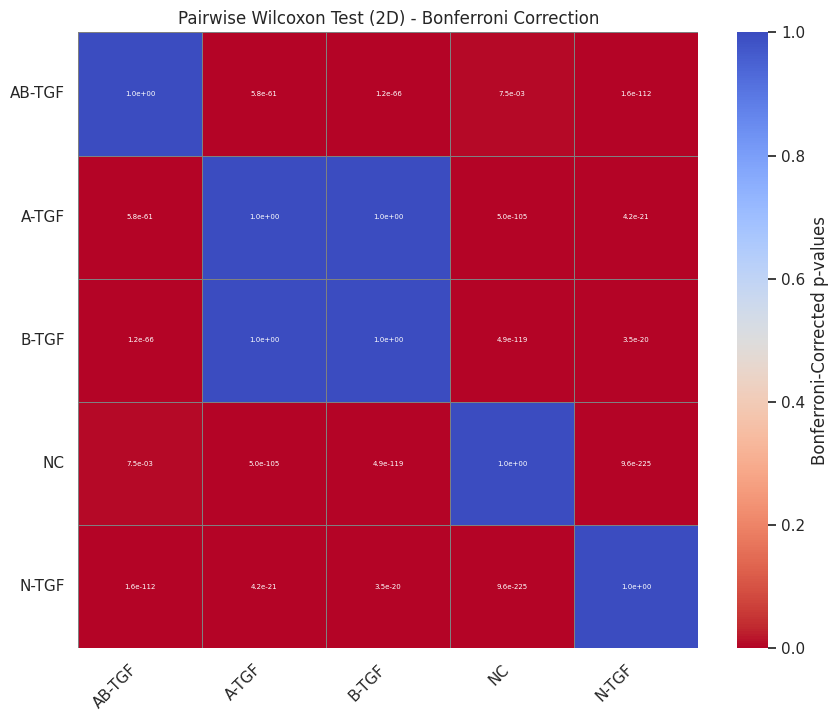

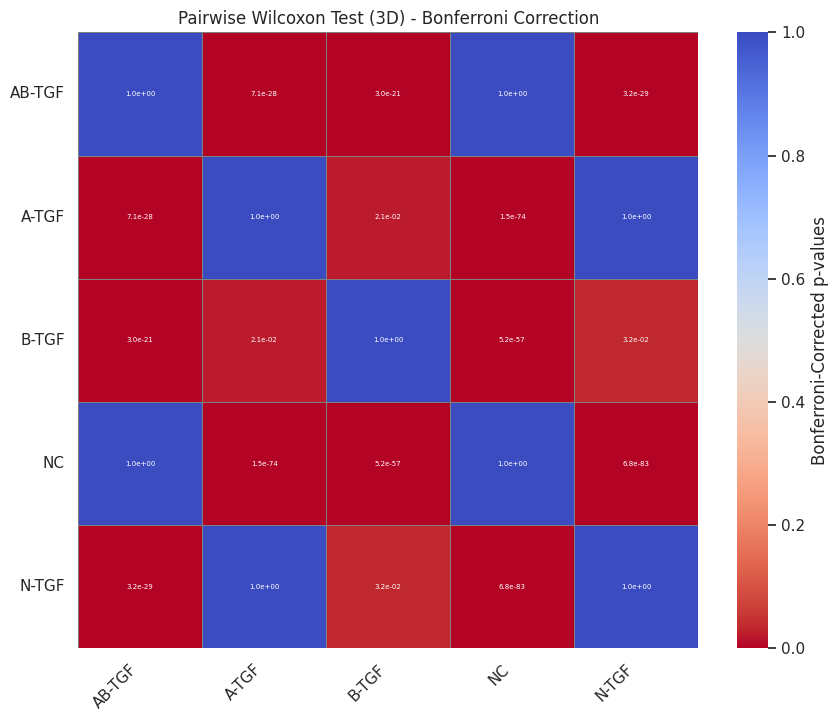

In [50]:
import pandas as pd
from scipy.stats import mannwhitneyu
from itertools import combinations
import numpy as np

# Function to compute pairwise Wilcoxon tests with Bonferroni correction
def pairwise_wilcoxon_bonferroni(df):
    categories = df['Category'].unique()
    p_values = pd.DataFrame(index=categories, columns=categories, dtype=float)
    n_comparisons = len(list(combinations(categories, 2)))  # Total number of pairwise comparisons

    raw_p_values = []  # Store raw p-values before correction

    for cat1, cat2 in combinations(categories, 2):
        group1 = df[df['Category'] == cat1]['Volume']
        group2 = df[df['Category'] == cat2]['Volume']
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
        raw_p_values.append((cat1, cat2, p))

    # Apply Bonferroni correction
    for cat1, cat2, p in raw_p_values:
        corrected_p = min(p * n_comparisons, 1)  # Adjust p-value and cap at 1
        p_values.loc[cat1, cat2] = corrected_p
        p_values.loc[cat2, cat1] = corrected_p  # Fill symmetric value

    np.fill_diagonal(p_values.values, 1)  # Set diagonal to 1 (self-comparison)
    return p_values

# Compute pairwise Wilcoxon test with Bonferroni correction for both 2D and 3D datasets
p_values_2d_bonferroni = pairwise_wilcoxon_bonferroni(df_2d)
p_values_3d_bonferroni = pairwise_wilcoxon_bonferroni(df_3d)

def plot_heatmap(p_values, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        p_values.astype(float),  # Ensure values are float for color mapping
        annot=True,  # Show p-values
        fmt=".1e",  # Scientific notation for small p-values
        cmap="coolwarm_r",  # Use a diverging colormap (red-blue)
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'Bonferroni-Corrected p-values'},
        annot_kws={"size": 5}
    )
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.yticks(rotation=0)
    plt.show()

# Plot heatmaps for 2D and 3D datasets
plot_heatmap(p_values_2d_bonferroni, "Pairwise Wilcoxon Test (2D) - Bonferroni Correction")
plot_heatmap(p_values_3d_bonferroni, "Pairwise Wilcoxon Test (3D) - Bonferroni Correction")